In [146]:
from abc import ABC
from abc import abstractmethod
from dataclasses import dataclass
from enum import Enum
from enum import auto
from itertools import combinations
from pprint import pprint
from typing import override
from unicodedata import normalize

import matplotlib.pyplot as plt
import nltk
import numpy as np
from datasets import load_dataset
from nltk.tokenize import sent_tokenize
from sentence_transformers import SentenceTransformer
from sentence_transformers import SimilarityFunction
from sentence_transformers import CrossEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from torch import diag
from tqdm import tqdm


In [147]:
nltk.download("punkt", download_dir='.nltk/')

[nltk_data] Downloading package punkt to .nltk/...
[nltk_data]   Package punkt is already up-to-date!


True

In [148]:
print('Loading datasets...')
dataset_snli = load_dataset('stanfordnlp/snli', split='test', cache_dir='.datasets/')
dataset_mnli = load_dataset('nyu-mll/multi_nli', split='validation_matched', cache_dir='.datasets/')
dataset_anli = load_dataset('facebook/anli', split='test_r3', cache_dir='.datasets/')
print('Loading datasets done.')

Loading datasets...
Loading datasets done.


In [149]:
class Label(Enum):
    ENTAILMENT = auto()
    NOT_ENTAILMENT = auto()
    NOT_AVAILABLE = auto()


@dataclass
class Example:
    premise: str
    hypothesis: str
    label: Label


class ExampleSNLI(Example):
    def __init__(self, example: dict):
        label = self._to_binary_class(example['label'])
        super().__init__(example['premise'], example['hypothesis'], label)
    
    def _to_binary_class(self, label: int) -> Label:
        return Label.ENTAILMENT if label == 0 else Label.NOT_ENTAILMENT


class ExampleMNLI(Example):
    def __init__(self, example: dict):
        label = self._to_binary_class(example['label'])
        super().__init__(example['premise'], example['hypothesis'], label)
    
    def _to_binary_class(self, label: int) -> Label:
        return Label.ENTAILMENT if label == 0 else Label.NOT_ENTAILMENT


class ExampleANLI(Example):
    def __init__(self, example: dict):
        label = self._to_binary_class(example['label'])
        super().__init__(example['premise'], example['hypothesis'], label)
    
    def _to_binary_class(self, label: int) -> Label:
        return Label.ENTAILMENT if label == 0 else Label.NOT_ENTAILMENT

In [150]:
examples_snli = [ExampleSNLI(example) for example in dataset_snli]
examples_mnli = [ExampleMNLI(example) for example in dataset_mnli]
examples_anli = [ExampleANLI(example) for example in dataset_anli]

In [151]:
class Model(ABC):
    @abstractmethod
    def predict(self, example: Example) -> int:
        pass
    
    @abstractmethod
    def predict_batch(self, examples: list[Example]) -> list[int]:
        pass

    @abstractmethod
    def tokenize(self, premise: str, hypothesis: str) -> list[int]:
        pass

    @abstractmethod
    def get_max_token_length(self) -> int:
        pass


class SBERTSimilarity(Model):
    def __init__(self, pretrained_model_name: str):
        self.model = SentenceTransformer(pretrained_model_name, similarity_fn_name=SimilarityFunction.COSINE)
        self.tokenizer = self.model.tokenizer
        self.max_token_length = self.model.tokenizer.model_max_length
        self.THRESHOLD = 0.7854461757884753 # from ordinal logistic regression on STS Benchmark 

    def similarity(self, example: Example) -> float:
        premise_sentences = sent_tokenize(example.premise)
        embeddings_premise = self.model.encode(premise_sentences)
        embeddings_hypothesis = self.model.encode([example.hypothesis])
        return self.model.similarity(embeddings_premise, embeddings_hypothesis)

    @override
    def predict(self, example: Example) -> Label:
        embeddings_premise = self.model.encode([example.premise])
        embeddings_hypothesis = self.model.encode([example.hypothesis])
        score = self.model.similarity(embeddings_premise, embeddings_hypothesis)[0][0]
        return Label.ENTAILMENT if score >= self.THRESHOLD else Label.NOT_ENTAILMENT
    
    @override
    def predict_batch(self, examples: list[Example]) -> list[Label]:
        embeddings_premise = self.model.encode([example.premise for example in examples])
        embeddings_hypothese = self.model.encode([example.hypothesis for example in examples])
        scores = self.model.similarity(embeddings_premise, embeddings_hypothese)
        return [Label.ENTAILMENT if score >= self.THRESHOLD else Label.NOT_ENTAILMENT for score in diag(scores)]
    
    @override
    def tokenize(self, premise: str, hypothesis: str) -> list[int]:
        tokens = self.tokenizer.tokenize(premise, hypothesis)
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        return token_ids
    
    @override
    def get_max_token_length(self) -> int:
        return self.max_token_length


class SBERTClassification(Model):
    def __init__(self, pretrained_model_name: str):
        self.model = CrossEncoder(pretrained_model_name)
        self.tokenizer = self.model.tokenizer
        self.max_token_length = self.model.tokenizer.model_max_length
        self.ENTAILMENT = 1 # see https://huggingface.co/cross-encoder/nli-deberta-v3-small
    
    @override
    def predict(self, example: Example) -> Label:
        score = self.model.predict([(example.premise, example.hypothesis)])[0]
        return Label.ENTAILMENT if np.argmax(score) == self.ENTAILMENT else Label.NOT_ENTAILMENT

    @override
    def predict_batch(self, examples: list[Example]) -> list[Label]:
        scores = self.model.predict([(example.premise, example.hypothesis) for example in examples])
        return [Label.ENTAILMENT if np.argmax(score) == self.ENTAILMENT else Label.NOT_ENTAILMENT for score in scores]

    @override
    def tokenize(self, premise: str, hypothesis: str) -> list[int]:
        tokens = self.tokenizer.tokenize(premise, hypothesis)
        token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        return token_ids

    @override
    def get_max_token_length(self) -> int:
        return self.max_token_length

In [152]:
def select_k_sentences(text: str, k: int) -> list[str]:
    sentences = sent_tokenize(normalize('NFKC', text))
    return [' '.join(comb) for comb in combinations(sentences, max(k, 0))]


def breakdown_sub_examples(model: Model, example: Example, max_of_select_sentences: int = 0) -> list[Example]:
    if max_of_select_sentences <= 0:
        return [Example(example.premise, example.hypothesis, Label.NOT_AVAILABLE)]

    sub_premises = []
    for k in range(1, max_of_select_sentences + 1):
        sub_premises.extend(select_k_sentences(example.premise, k))
    
    # remove duplicated sentences
    sub_premises = list(set(sub_premises)) 

    sub_examples = []
    max_token_length = model.get_max_token_length()
    for sub_premise in sub_premises:
        tokens = model.tokenize(sub_premise, example.hypothesis)

        # skip this sub-example if it would exceed the model's token limit
        if len(tokens) > max_token_length:  
            continue

        sub_examples.append(Example(sub_premise, example.hypothesis, Label.NOT_AVAILABLE))
    return sub_examples

In [153]:
def metrics(y_true: list[Label], y_pred: list[Label]) -> tuple[float, float, float, float]:
    y_true = [1 if label == Label.ENTAILMENT else 0 for label in y_true]
    y_pred = [1 if label == Label.ENTAILMENT else 0 for label in y_pred]
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    return accuracy, precision, recall, f1


def any_entailment(y_pred: list[Label]) -> Label:
    return Label.ENTAILMENT if any(label == Label.ENTAILMENT for label in y_pred) else Label.NOT_ENTAILMENT


def evaluate_model(model: Model, examples: list[Example], max_of_select_sentences: int = 0) -> dict:
    y_true = [example.label for example in examples]
    y_pred = []

    # flatten all sub-examples, and predict them at once
    all_sub_examples = []
    num_of_sub_examples = []
    for example in examples:
        sub_examples = breakdown_sub_examples(model, example, max_of_select_sentences)
        all_sub_examples.extend(sub_examples)
        num_of_sub_examples.append(len(sub_examples))
    all_pred_labels = model.predict_batch(all_sub_examples)
    offset = 0
    for num_of_sub_example in num_of_sub_examples:
        sub_pred_labels = all_pred_labels[offset : offset + num_of_sub_example]
        offset += num_of_sub_example
        y_pred.append(any_entailment(sub_pred_labels))

    accuracy, precision, recall, f1 = metrics(y_true, y_pred)
    return { 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1 }

In [154]:
model_classification = SBERTClassification('cross-encoder/nli-deberta-v3-small')

print('Evaluating model on ANLI...')
metrics_anli = evaluate_model(model_classification, examples_anli)
pprint(metrics_anli)

Evaluating model on ANLI...
{'accuracy': 0.6066666666666667,
 'f1': 0.2053872053872054,
 'precision': 0.3177083333333333,
 'recall': 0.1517412935323383}


In [155]:
model_similarity = SBERTSimilarity('sentence-transformers/all-MiniLM-L6-v2')

print('Evaluating model on ANLI...')
metrics_anli = evaluate_model(model_similarity, examples_anli)
pprint(metrics_anli)

Evaluating model on ANLI...
{'accuracy': 0.635,
 'f1': 0.09504132231404959,
 'precision': 0.2804878048780488,
 'recall': 0.05721393034825871}


In [156]:
scores_classification: dict[int, object] = {}
scores_similarity: dict[int, object] = {}
for max_of_select_sentences in tqdm(range(1, 5)):
    metrics_classification = evaluate_model(model_classification, examples_anli, max_of_select_sentences=max_of_select_sentences)
    scores_classification[max_of_select_sentences] = metrics_classification
    metrics_similarity = evaluate_model(model_similarity, examples_anli, max_of_select_sentences=max_of_select_sentences)
    scores_similarity[max_of_select_sentences] = metrics_similarity

100%|██████████| 4/4 [01:03<00:00, 15.77s/it]


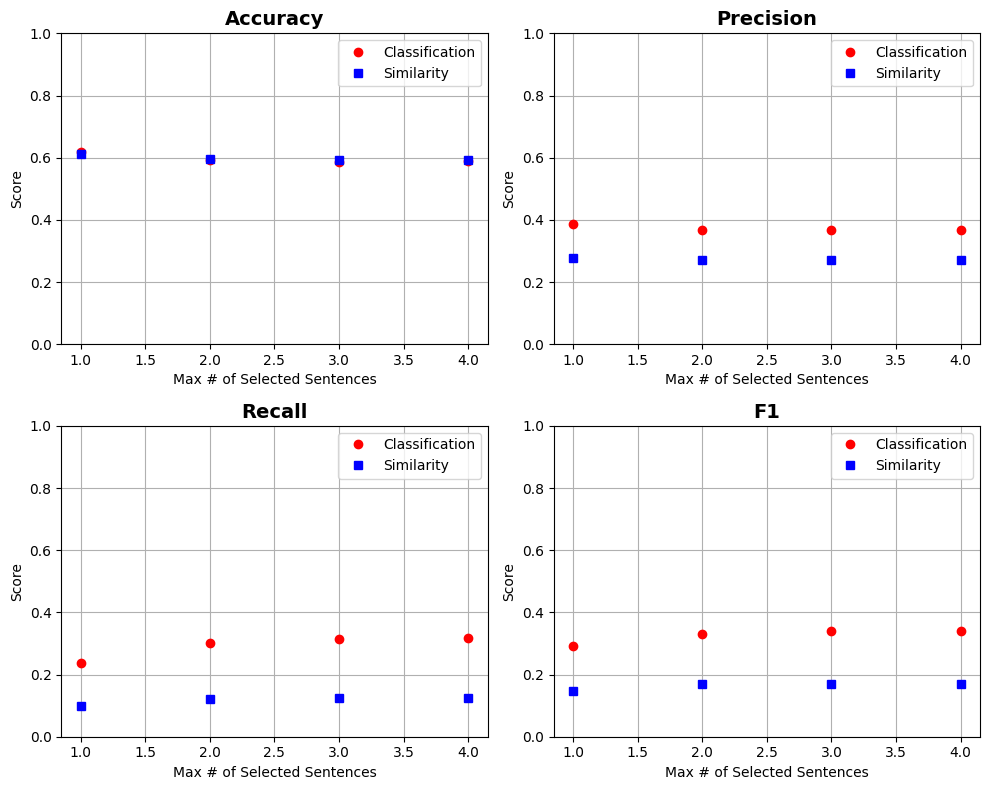

In [171]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(scores_classification.keys(), [score['accuracy'] for score in scores_classification.values()], 'ro', label='Classification')
ax[0, 1].plot(scores_classification.keys(), [score['precision'] for score in scores_classification.values()], 'ro', label='Classification')
ax[1, 0].plot(scores_classification.keys(), [score['recall'] for score in scores_classification.values()], 'ro', label='Classification')
ax[1, 1].plot(scores_classification.keys(), [score['f1'] for score in scores_classification.values()], 'ro', label='Classification')
ax[0, 0].plot(scores_similarity.keys(), [score['accuracy'] for score in scores_similarity.values()], 'bs', label='Similarity')
ax[0, 1].plot(scores_similarity.keys(), [score['precision'] for score in scores_similarity.values()], 'bs', label='Similarity')
ax[1, 0].plot(scores_similarity.keys(), [score['recall'] for score in scores_similarity.values()], 'bs', label='Similarity')   
ax[1, 1].plot(scores_similarity.keys(), [score['f1'] for score in scores_similarity.values()], 'bs', label='Similarity')

titles = ['Accuracy', 'Precision', 'Recall', 'F1']
for i in range(2):
    for j in range(2):
        ax[i, j].set_title(titles[2*i + j], fontsize=14, fontweight='bold')
        ax[i, j].set_xlabel('Max # of Selected Sentences')
        ax[i, j].set_ylabel('Score')
        ax[i, j].set_ylim(0, 1)
        ax[i, j].grid(True)
        ax[i, j].legend(loc='upper right')

plt.tight_layout()
plt.show()
